**Loading Data**

*   Firstly I am connecting Google Colab with Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



*   My data set is about age of people and it has five categories.

*   Images are in a zip file in Drive, which name is faceage.zip. 
*   I am showing the zip file path.

In [2]:
zip_adres = "/content/drive/MyDrive/kerasders/faceage.zip"
!cp "{zip_adres}" .

*   Unzipping data and removing it.

In [3]:
!unzip -q faceage.zip
!rm faceage.zip

*   Importing pandas and keras library and learning keras version.

In [4]:
import pandas as pd

import keras
keras.__version__

'2.4.3'

**VGG 16**


*   Importing VGG16 and assigning value to it.

In [5]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


*   Showing VGG16 layers. It has 14,714,688 trainable parameters.

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

*   Reading train, validation and test data.
*   Extracting features from data by the predict method.

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/faceage'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 250)
test_features, test_labels = extract_features(test_dir, 250)

Found 1000 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.



*   Visulationing our categories with a pie plot.



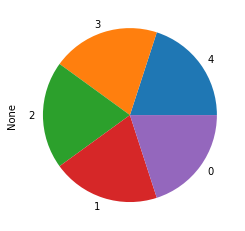

In [8]:
pd.Series(np.argmax(train_labels, 1)).value_counts().plot.pie()

In [9]:
train_features = np.reshape(train_features, (1000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (250, 4 * 4 * 512))
test_features = np.reshape(test_features, (250, 4 * 4 * 512))



*   Adding dense layer to model and fitting it.




In [10]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
50/50 [==============================] - 1s 11ms/step - loss: 1.7981 - acc: 0.2061 - val_loss: 1.4429 - val_acc: 0.4280
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 1.5635 - acc: 0.3173 - val_loss: 1.3036 - val_acc: 0.5440
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 1.3424 - acc: 0.4377 - val_loss: 1.2060 - val_acc: 0.6200
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 1.2782 - acc: 0.4541 - val_loss: 1.1291 - val_acc: 0.6520
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 1.1858 - acc: 0.5046 - val_loss: 1.0788 - val_acc: 0.6320
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 1.1598 - acc: 0.5156 - val_loss: 1.0216 - val_acc: 0.6920
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 1.1191 - acc: 0.5458 - val_loss: 0.9762 - val_acc: 0.6840
Epoch 8/30
50/50 [==============================] - 0s 4ms/step - loss: 1.0338 - acc: 0.5


After 50 epocs:
*   Accuracy is almost 80%.
*   Validation accuracy is almost 90%.
*   Plotting values for per epocs.






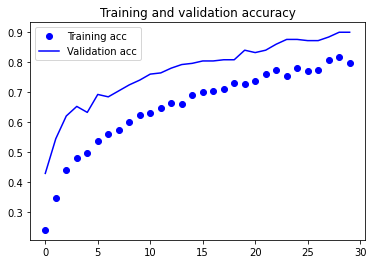

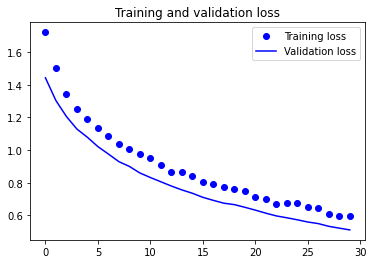

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



*   Making VGG16 layers frozen.



In [12]:
conv_base.trainable = False



*   Adding Dense layers and changeing the model.




In [13]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

*   Learning the model layers. Now it is 2,196,741 trainable parameters.




In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 16,911,429
Trainable params: 2,196,741
Non-trainable params: 14,714,688
__________________________________

In [15]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 8


In [16]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 8



**Preprocessing**
*   Preprocessing data and using it for fitting model again.




In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-3),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=int(train_generator.n/train_generator.batch_size),
      epochs=50,
      validation_data=validation_generator,
      validation_steps=int(validation_generator.n/validation_generator.batch_size),
      verbose=1)

Found 1000 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Epoch 1/50
50/50 [==============================] - 8s 156ms/step - loss: 2.3436 - acc: 0.2924 - val_loss: 1.0993 - val_acc: 0.5583
Epoch 2/50
50/50 [==============================] - 7s 150ms/step - loss: 1.2339 - acc: 0.4645 - val_loss: 0.9773 - val_acc: 0.5792
Epoch 3/50
50/50 [==============================] - 8s 150ms/step - loss: 1.1282 - acc: 0.5128 - val_loss: 0.9816 - val_acc: 0.5667
Epoch 4/50
50/50 [==============================] - 7s 150ms/step - loss: 1.1356 - acc: 0.5010 - val_loss: 0.9216 - val_acc: 0.5875
Epoch 5/50
50/50 [==============================] - 7s 149ms/step - loss: 1.0274 - acc: 0.5716 - val_loss: 0.9208 - val_acc: 0.6208
Epoch 6/50
50/50 [==============================] - 7s 149ms/step - loss: 1.0199 - acc: 0.5669 - val_loss: 0.8660 - val_acc: 0.6542
Epoch 7/50
50/50 [==============================] - 7s 149ms/step - loss: 0.9752 - acc: 0.5682 - val_loss: 0.8035 - val_acc: 

After 50 epocs:
*   Accuracy is almost 70%.
*   Validation accuracy is almost 77%.
*   Plotting values for per epocs.

In [18]:
model.save('face_age.h5')

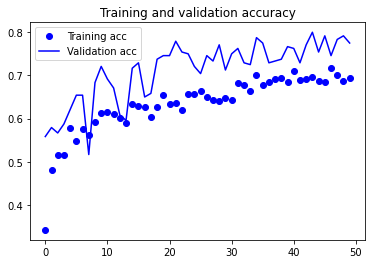

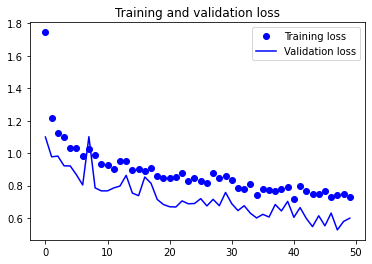

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



*   Checking VGG16 layers. It has no trainable parameters.



In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     



*   Making unfrozen fifth layer on VGG16.




In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False



*   Changing model and fitting it with preprocessed data.
*   Learning the accuracy values.



In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=int(train_generator.n/train_generator.batch_size),
      epochs=50,
      validation_data=validation_generator,
      validation_steps=int(validation_generator.n/validation_generator.batch_size),
      verbose=1)

Epoch 1/50
50/50 [==============================] - 9s 161ms/step - loss: 0.7213 - acc: 0.7031 - val_loss: 0.4954 - val_acc: 0.8000
Epoch 2/50
50/50 [==============================] - 8s 155ms/step - loss: 0.6820 - acc: 0.7187 - val_loss: 0.5179 - val_acc: 0.7917
Epoch 3/50
50/50 [==============================] - 8s 155ms/step - loss: 0.5995 - acc: 0.7581 - val_loss: 0.4352 - val_acc: 0.8250
Epoch 4/50
50/50 [==============================] - 8s 155ms/step - loss: 0.6076 - acc: 0.7412 - val_loss: 0.4543 - val_acc: 0.8250
Epoch 5/50
50/50 [==============================] - 8s 157ms/step - loss: 0.6372 - acc: 0.7476 - val_loss: 0.4584 - val_acc: 0.7750
Epoch 6/50
50/50 [==============================] - 8s 157ms/step - loss: 0.5894 - acc: 0.7781 - val_loss: 0.5470 - val_acc: 0.7917
Epoch 7/50
50/50 [==============================] - 8s 155ms/step - loss: 0.6675 - acc: 0.7127 - val_loss: 0.4398 - val_acc: 0.8125
Epoch 8/50
50/50 [==============================] - 8s 155ms/step - loss: 0.

After making unfrozen the fifth layer, accuracy increased.

After 50 epocs:
*   Accuracy is almost 90%.
*   Validation accuracy is almost 95%.
*   Plotting values for per epocs.

In [23]:
model.save('face_age_2.h5')

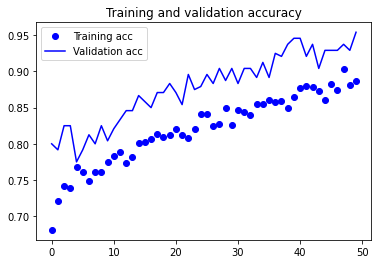

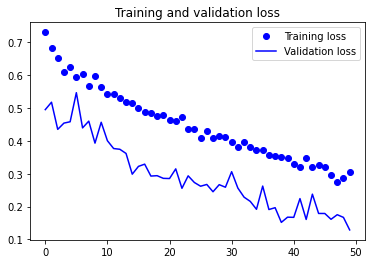

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



*   For increasing readability plotting it with average values.




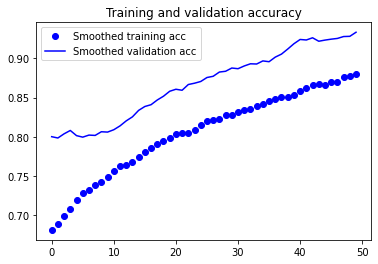

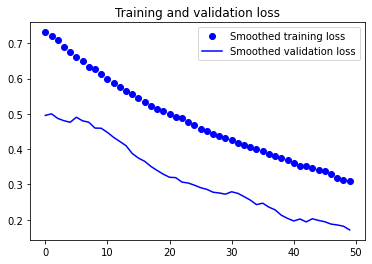

In [25]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*   Learning test accuracy:





In [26]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n/test_generator.batch_size)
print('test acc:', test_acc)

Found 250 images belonging to 5 classes.
12/12 [==============================] - 1s 56ms/step - loss: 0.8954 - acc: 0.7200
test acc: 0.7200000286102295




*   Test Accuracy is almost 72%






*   Trying with opening fourth layer on VGG16 aswell.



In [27]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 16,911,429
Trainable params: 15,175,941
Non-trainable params: 1,735,488
__________________________________

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=int(train_generator.n/train_generator.batch_size),
      epochs=50,
      validation_data=validation_generator,
      validation_steps=int(validation_generator.n/validation_generator.batch_size),
      verbose=1)

Epoch 1/50
50/50 [==============================] - 9s 165ms/step - loss: 0.5690 - acc: 0.8141 - val_loss: 0.1719 - val_acc: 0.9375
Epoch 2/50
50/50 [==============================] - 8s 163ms/step - loss: 0.3037 - acc: 0.8781 - val_loss: 0.1734 - val_acc: 0.9417
Epoch 3/50
50/50 [==============================] - 8s 163ms/step - loss: 0.3313 - acc: 0.8774 - val_loss: 0.2434 - val_acc: 0.9083
Epoch 4/50
50/50 [==============================] - 8s 164ms/step - loss: 0.3458 - acc: 0.8561 - val_loss: 0.1230 - val_acc: 0.9583
Epoch 5/50
50/50 [==============================] - 8s 164ms/step - loss: 0.3581 - acc: 0.8743 - val_loss: 0.1694 - val_acc: 0.9500
Epoch 6/50
50/50 [==============================] - 8s 164ms/step - loss: 0.3202 - acc: 0.8862 - val_loss: 0.1789 - val_acc: 0.9292
Epoch 7/50
50/50 [==============================] - 8s 164ms/step - loss: 0.3089 - acc: 0.8654 - val_loss: 0.1608 - val_acc: 0.9333
Epoch 8/50
50/50 [==============================] - 8s 166ms/step - loss: 0.

Accuracy values are increased.

After 50 epocs:
*   Accuracy is almost 96%.
*   Validation accuracy is almost 98%.
*   Plotting values for per epocs.

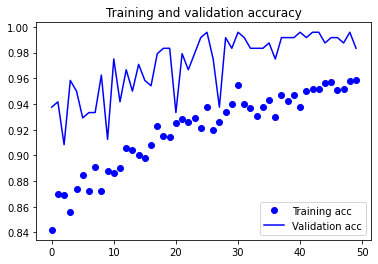

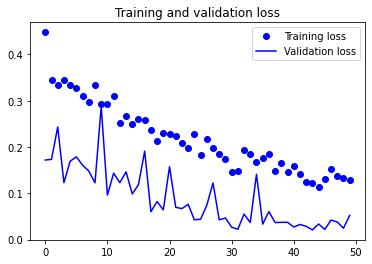

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

*   Checking test accuracy:

In [32]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n/test_generator.batch_size)
print('test acc:', test_acc)

Found 250 images belonging to 5 classes.
12/12 [==============================] - 1s 62ms/step - loss: 1.3251 - acc: 0.7760
test acc: 0.7760000228881836


Test accuracy is also increased.

*   Test Accuracy is almost 78%.

